In [1]:
from ultralytics import YOLO, settings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
import torch
import cv2
import os

torch.cuda.empty_cache()
CUDA = torch.cuda.is_available()
print("CUDA is available:", CUDA)

CUDA is available: True


In [2]:
MODEL_PATH_SEGMENT = '../models/plant_segmentation_v1.pt'
IMG_PATH_FIXED = '../images/cropped_scales/fixed'
IMG_PATH_RANDOM = '../images/cropped_scales/random'
DATA_PATH = '../data/processed'
DEVICE = "cuda" if CUDA else "cpu"
settings.update({'runs_dir': rf'/home/floris/Projects/NTNU/models/runs'})

model_seg = YOLO(MODEL_PATH_SEGMENT)

In [3]:
def measure_scale_random(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    _max = 0
    _max_idx = 0
    for idx, c in enumerate(contours):
        x, y, w, h = cv2.boundingRect(c)
        if h > w:
            if abs(w - h) < 10 and w >= 0.18 * image.shape[0]:
                _max_idx = idx if w > _max else _max_idx
                _max = max(w, _max)
        else:
            if abs(w - h) < 10 and w >= 0.18 * image.shape[1]:
                _max_idx = idx if h > _max else _max_idx
                _max = max(h, _max)

    _, _, w, h = cv2.boundingRect(contours[_max_idx])

    px_per_cm_w = w / 2
    px_per_cm_h = h / 2
    px_per_cm = (px_per_cm_w + px_per_cm_h) / 2

    return px_per_cm

def measure_scale_fixed_via_colorboard(image_path, box_width_mm=6.2):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    lower_red = np.array([100, 0, 0])
    upper_red = np.array([255, 100, 100])
    mask = cv2.inRange(image_rgb, lower_red, upper_red)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    _, _, w, _ = cv2.boundingRect(largest_contour)
    pixels_per_cm = w / (box_width_mm / 10)
    return pixels_per_cm

def transform_px_to_cm(box, px_per_cm):
    """
    Function to transform the width and height of a box from pixels to cm
    """
    try:
        w = np.abs((box[2] - box[0]).cpu())
        h = np.abs((box[3] - box[1]).cpu())
    except:
        w = np.abs(box[2] - box[0])
        h = np.abs(box[3] - box[1])
    return w / px_per_cm, h / px_per_cm

def get_masked_image(image, mask):
    """
    Apply a mask to an image with transparency
    """
    # Remove single-dimensional entry from the shape of the mask
    mask_squeezed = np.squeeze(mask)  # This should change mask shape to (5831, 3391)
    # Generate an alpha channel where mask is True (255) and False (0)
    alpha_channel = np.where(mask_squeezed, 255, 0).astype(np.uint8)
    # Ensure alpha channel is correctly shaped [H, W] -> [H, W, 1]
    alpha_channel_shaped = np.expand_dims(alpha_channel, axis=-1)

    # print("Image shape:", image.size)
    # print("Alpha channel shape:", alpha_channel_shaped.shape)

    # Concatenate the alpha channel with the image to create an RGBA image
    rgba_image = np.concatenate((image, alpha_channel_shaped), axis=-1)
    return rgba_image

def get_cropped_image(image, box):
    """
    Crop an image with a given box
    """
    if isinstance(box, list):
        box = box[0]
    if isinstance(box, torch.Tensor):
        box = box.cpu().numpy() 
    else:
        box = np.array(box) 

    if len(box.shape) > 1:
        box = box[0]
    x, y, w, h = int(box[0]), int(box[1]), int(box[2] - box[0]), int(box[3] - box[1])
    return image[y:y+h, x:x+w]

def apply_crop_mask(image, mask, box):
    """
    Apply a mask to an image and crop the image with a given box
    Returns a list of tuples with the masked image and the cropped image
    """
    images = []
    if len(np.array(mask).shape) == 3:
        for i, m in enumerate(mask):
            m_img = get_masked_image(image, m)
            b = box[i].cpu().numpy() if type(box) == torch.Tensor else box[i]
            crop_img = get_cropped_image(m_img, b)
            images.append((m_img, crop_img))
    else:
        m_img = get_masked_image(image, mask)
        b = box.cpu().numpy() if type(box) == torch.Tensor else box
        crop_img = get_cropped_image(m_img, b)
        images.append((m_img, crop_img))
    return images

def find_dominant_color(image, k=3):
    # Convert image to numpy array
    img_array = np.array(image)
    # Reshape it to a list of RGB values
    img_vector = img_array.reshape((-1, 3))
    # Run k-means on the pixel colors (fit only on a subsample to speed up)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_vector[::50])
    # Get the dominant color
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    # Create a mask for pixels within a certain distance from the dominant color
    distances = np.sqrt(np.sum((img_vector - dominant_color) ** 2, axis=1))
    mask = distances < np.std(distances)
    # Turn the dominant color range to white
    img_vector[mask] = [255, 255, 255]
    result_img_array = img_vector.reshape(img_array.shape)
    # turn image back to PIL
    result_img = Image.fromarray(result_img_array.astype(np.uint8))
    return dominant_color, result_img

def calculate_mask_area(masked_pixels, pixels_per_cm):
    area_square_cm = masked_pixels / (pixels_per_cm ** 2)
    return area_square_cm

def get_images(path, range_left=0, range_right=-1):
    if not os.path.exists(path):
        print(f"Path {path} does not exist")
        return []
    if len(os.listdir(path)) == 0:
        print(f"Path {path} is empty")
        return []
    
    images = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') and 'only' not in f and 'grid' not in f]
    return images[range_left:range_right]

def calc_non_transparent_pixel_count(image):
    if type(image) == str:
        image = Image.open(image)
    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    if type(image) == Image.Image:
        image = image
    assert image.mode == 'RGBA', "Image is not in RGBA mode"
    img_arr = np.array(image)
    ntp = np.where(img_arr[:, :, 3] != 0)
    return len(ntp[0])

def white_to_transparent(image, threshold=250):
    pil_img = Image.fromarray(image)
    assert pil_img.mode == 'RGBA'
    datas = pil_img.getdata()
    new_image_data = []
    for item in datas:
        if item[0] > threshold and item[1] > threshold and item[2] > threshold:
            new_image_data.append((255, 255, 255, 0))
        else:
            new_image_data.append(item)
    pil_img.putdata(new_image_data)
    return pil_img

def get_results(image, path, model, _class, conf, fdc=True):

    run_path = '/home/floris/Projects/NTNU/models/runs/segment'
    if os.path.exists(run_path):
        shutil.rmtree(run_path)

    if fdc:
        image = find_dominant_color(image)[1]
    results = model(image, retina_masks=True, verbose=False, conf=conf)

    processed_results = []

    for res in results:
        boxes = res.boxes.xyxy.cpu().numpy()
        masks = res.masks.data.cpu().numpy()
        original = res.orig_img
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        masked_cropped_images = apply_crop_mask(original, masks, boxes)
        image_path = path

        scale_only_path = image_path.replace('.jpg', '_scale_only.jpg')
        if _class == 'fixed':
            px_per_cm = measure_scale_fixed_via_colorboard(scale_only_path)
        if _class == 'random':
            px_per_cm = measure_scale_random(scale_only_path)

        all_boxes = []
        for box in boxes:
            w_cm, h_cm = transform_px_to_cm(box, px_per_cm)
            all_boxes.append((box, {'width_cm': w_cm, 'height_cm': h_cm}))
        
        all_mask_crop_with_sq_cm = []
        for m_img, c_img in masked_cropped_images:
            pil_img = white_to_transparent(c_img)
            ntpx = calc_non_transparent_pixel_count(pil_img)
            area = calculate_mask_area(ntpx, px_per_cm)
            all_mask_crop_with_sq_cm.append((m_img, c_img, area))
        
        processed_results.append({'image': original, 'image_path': image_path, 'px_per_cm': px_per_cm, 'boxes': all_boxes, 'masks_crops_sqcm': all_mask_crop_with_sq_cm})
        
    return processed_results

def show_img_mask_crop(images, original):
    images = [i[1] for i in images]
    images.insert(0, original)

    n_cols = 3
    total_images = len(images)
    n_rows = total_images // n_cols + (1 if total_images % n_cols > 0 else 0)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    ax = ax.flatten()

    for idx, img in enumerate(images):
        ax[idx].imshow(img)
        ax[idx].axis('off')

    for idx in range(len(images), len(ax)):
        ax[idx].axis('off')

    plt.show()

get_results function:

1. finds dominant color (background color) on image and replaces it with RGB(255, 255, 255) (full white) -> returns image with background white
2. runs the segment model on this white background image -> returns boxes, masks and original image (and other things that can be found in the 'results')
3. take the xyxy boxes, the masks and use apply_crop_mask function -> returns list of tupels which contain the masked_image and the mask_cropped_image
4. calculate results
    - calculate pixels per cm using the cropped scale of that image
    - calculate the width and height per bounding box in cm
    - calculate the cm² per transparant image (sum of all non-transparant pixels / (pixels_per_cm ^ 2))
5. results returned in a dictionary format

Dictionary keys:
dict_keys(['image', 'image_path', 'px_per_cm', 'boxes', 'masks_crops_sqcm'])
Mask 1: 65.33cm²


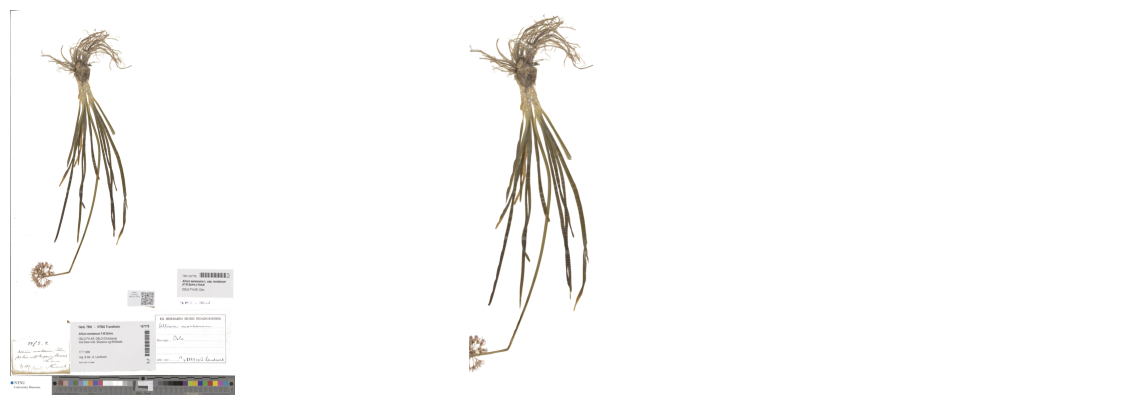

In [11]:
_class = 'fixed'

img_path = f'/home/floris/Projects/NTNU/images/cropped_scales/{_class}/'
images = get_images(img_path)
PIL_images = [Image.open(os.path.join(img_path, img)) for img in images[43:44]]

test_img = PIL_images[0]
test_img_path = os.path.join(img_path, images[0])

results = get_results(image=test_img, path=test_img_path, model=model_seg, _class=_class, conf=0.7, fdc=True)

print("Dictionary keys:")
print(results[0].keys())

for idx, res in enumerate(results[0]['masks_crops_sqcm']):
    print(f"Mask {idx+1}: {res[2]:.2f}cm²")

show_img_mask_crop(results[0]['masks_crops_sqcm'], results[0]['image'])